In [214]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
import xgboost as xgb 

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [215]:
df = pd.read_csv('data/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [216]:
df.tail()


,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


<Axes: title={'center': 'Energy Use in MW'}, xlabel='Datetime'>

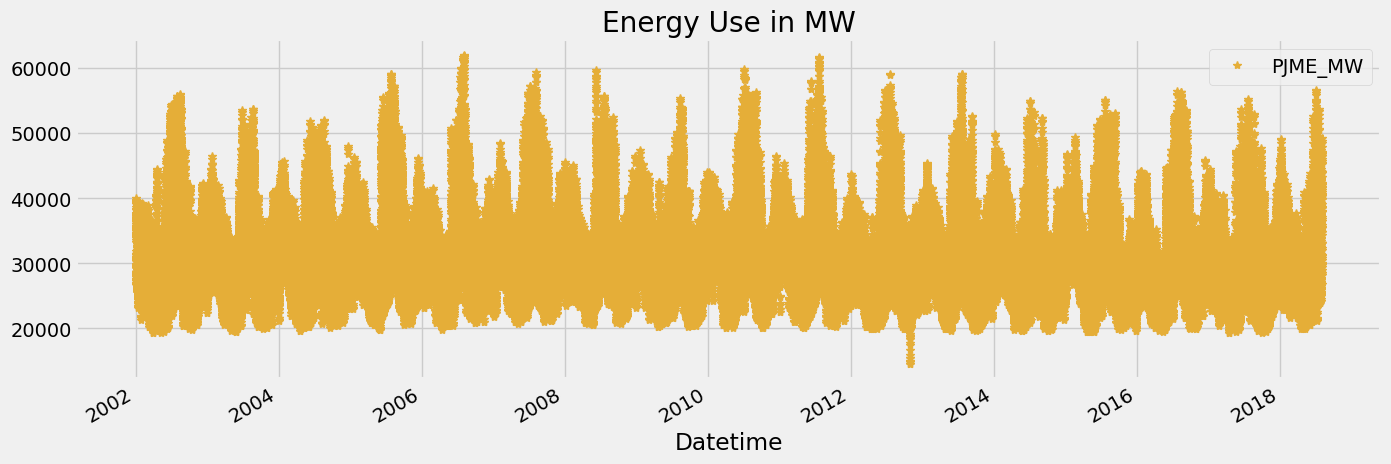

In [217]:
df.plot(style="*",figsize=(15,5),color=color_pal[2],title='Energy Use in MW')

#### Train Test Data Split

In [218]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

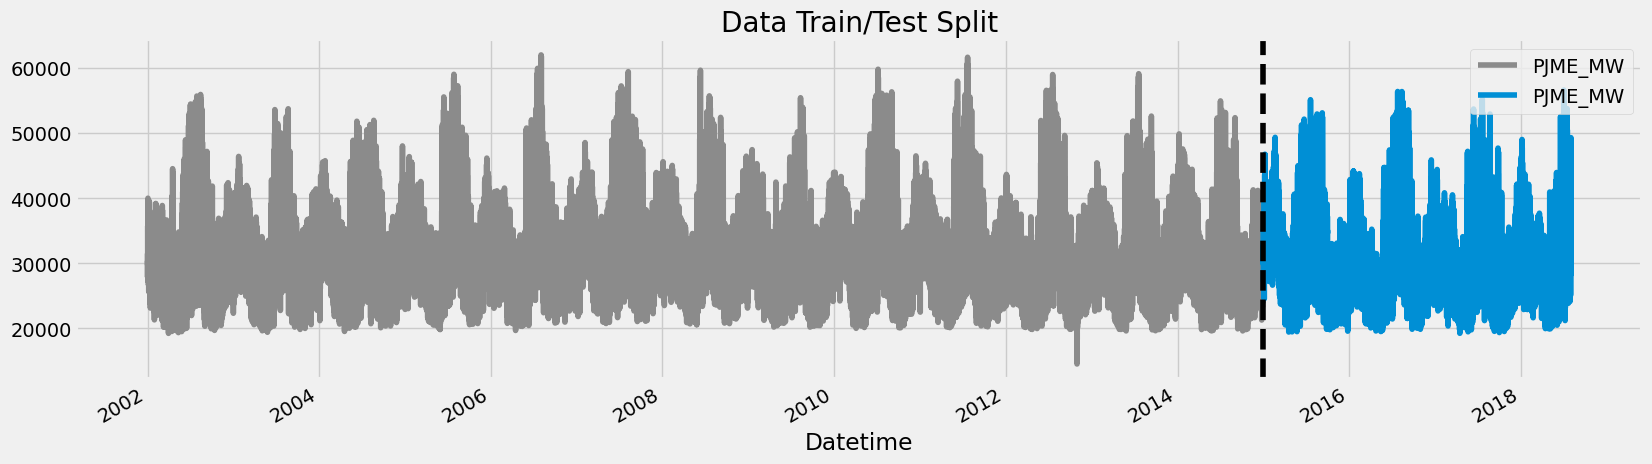

In [219]:
fig, ax = plt.subplots(figsize=(18,5))
train.plot(ax = ax,label='Train', title='Data Train/Test Split',color=color_pal[4])
test.plot(ax = ax,label ='Test')
ax.axvline('01-01-2015',color='black', ls='--')
plt.legend()
plt.show()

<Axes: xlabel='Datetime'>

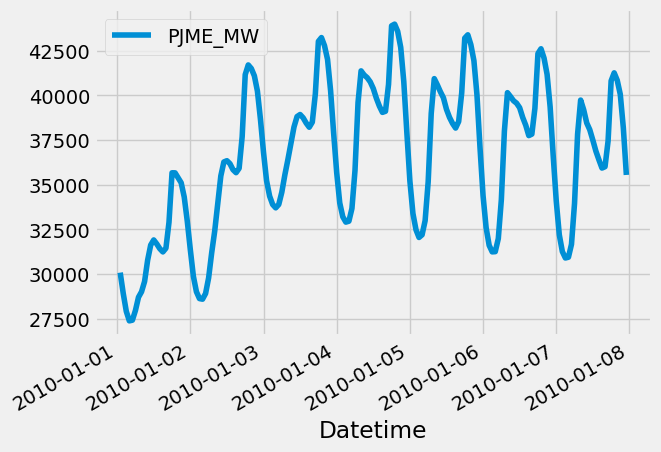

In [220]:
df.loc[(df.index >'01-01-2010') & (df.index < '01-08-2010')].plot()

## Feature Creation

In [221]:
def create_features(df):
    '''Create a time series features based on time-series index.'''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

### Visualizing Feature/Target Relationship

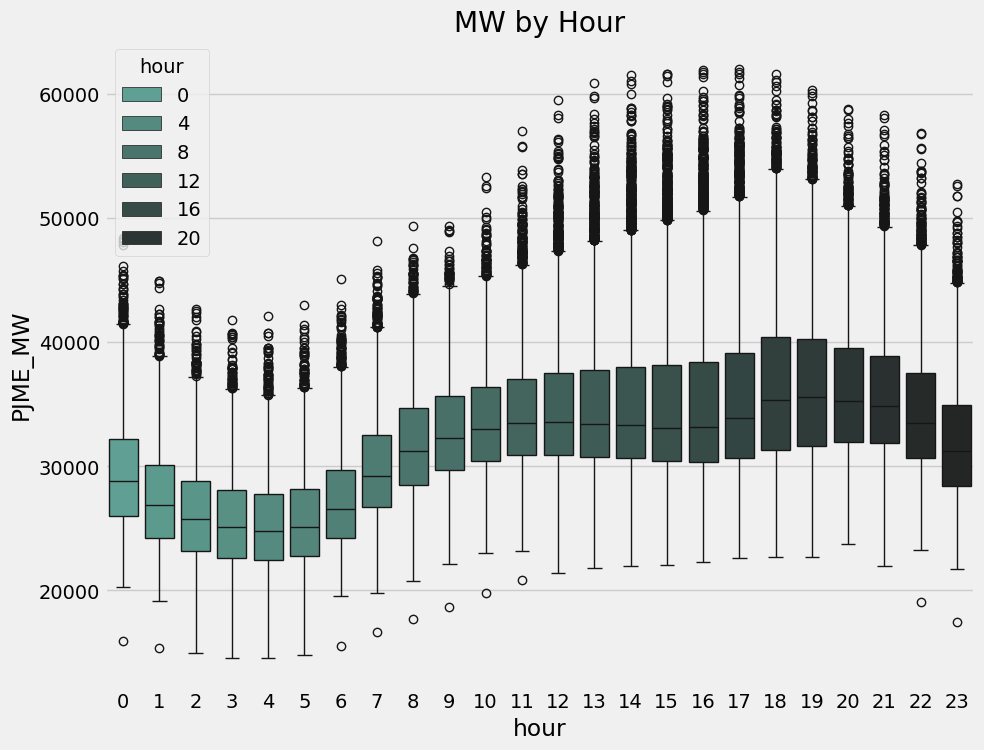

In [222]:
# By Hour
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW', hue='hour',palette="dark:#5A9_r")
ax.set_title('MW by Hour')
plt.show()

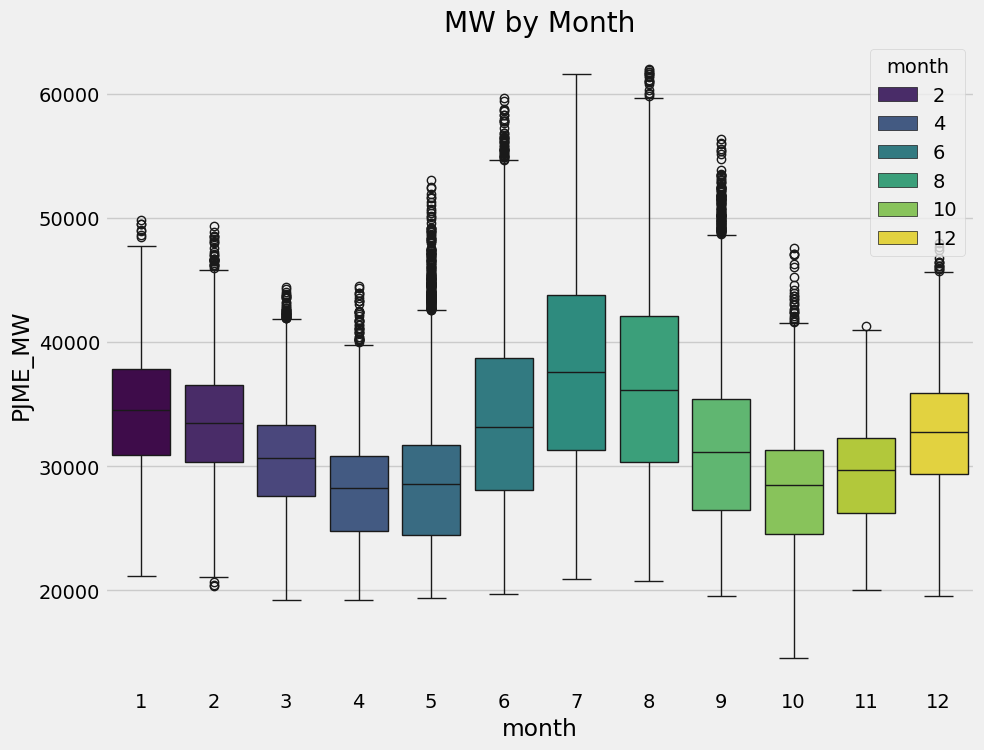

In [223]:
# By Month
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW',color=color_pal[1],hue='month',palette='viridis')
ax.set_title('MW by Month')
plt.show()

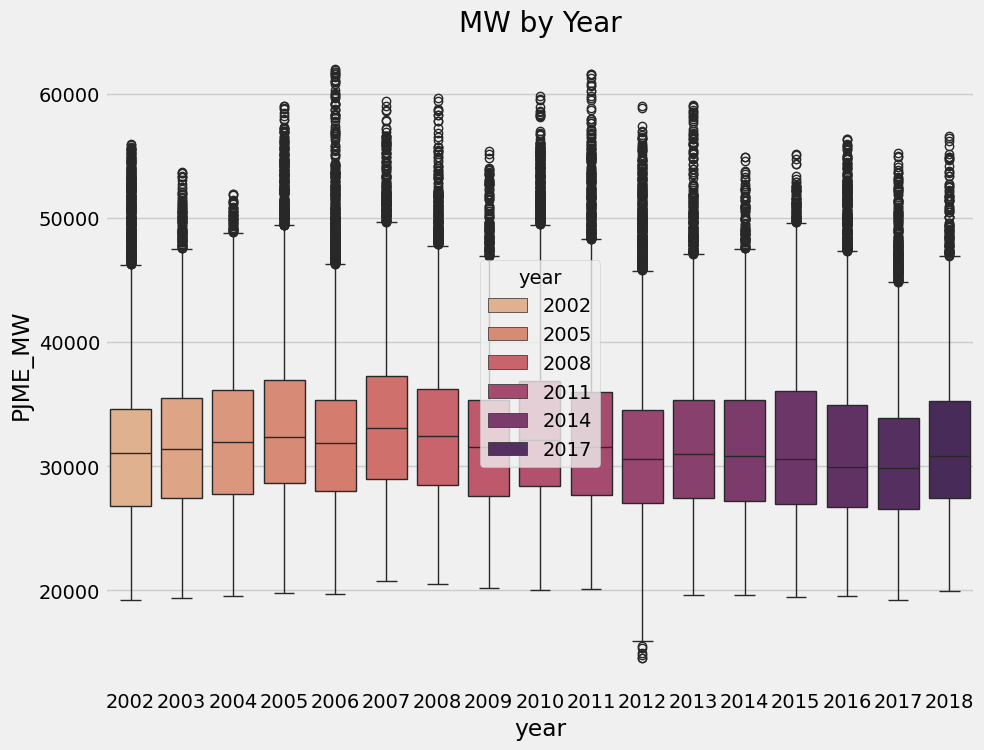

In [224]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='year', y='PJME_MW',hue='year',palette='flare')
ax.set_title('MW by Year')
plt.show()

### XGBoost Model

In [225]:
train = create_features(train)
test = create_features(test)
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [226]:
FEAT = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']

TARGET = 'PJME_MW'

In [227]:
X_train = train[FEAT]
y_train = train[TARGET]

X_test = test[FEAT]
y_test = test[TARGET]

In [228]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=60,
learning_rate=0.001)
reg.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_test,y_test)],
verbose=100)

[0]	validation_0-rmse:6447.78573	validation_1-rmse:6517.54145


[100]	validation_0-rmse:6026.49339	validation_1-rmse:6131.08053
[200]	validation_0-rmse:5654.75124	validation_1-rmse:5796.65490
[300]	validation_0-rmse:5326.88030	validation_1-rmse:5505.59274
[400]	validation_0-rmse:5039.56899	validation_1-rmse:5253.21086
[500]	validation_0-rmse:4788.58887	validation_1-rmse:5034.74880
[600]	validation_0-rmse:4565.97498	validation_1-rmse:4847.76655
[700]	validation_0-rmse:4372.19812	validation_1-rmse:4687.11295
[800]	validation_0-rmse:4202.53312	validation_1-rmse:4547.57144
[900]	validation_0-rmse:4055.65261	validation_1-rmse:4427.00726
[999]	validation_0-rmse:3929.32983	validation_1-rmse:4325.35302


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Feature Importances

In [229]:
fi = pd.DataFrame(data=reg.feature_importances_,
index=reg.feature_names_in_,columns=['Importance'])

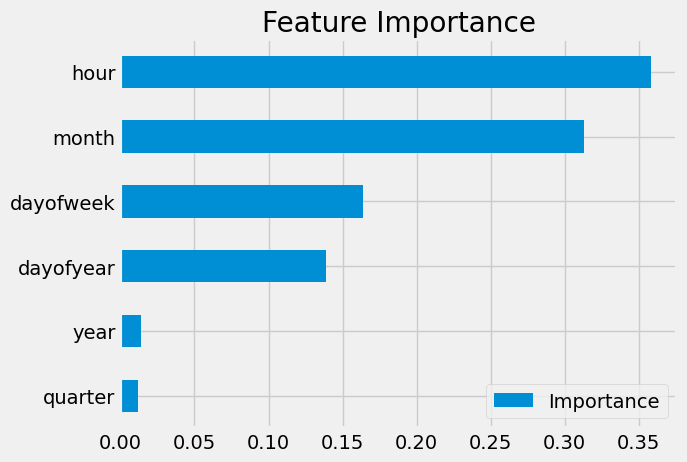

In [230]:
fi.sort_values('Importance').plot(kind='barh',title='Feature Importance')
plt.show()

### Forecast on Test

In [231]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']],how='left',left_index=True,right_index=True)

In [232]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN


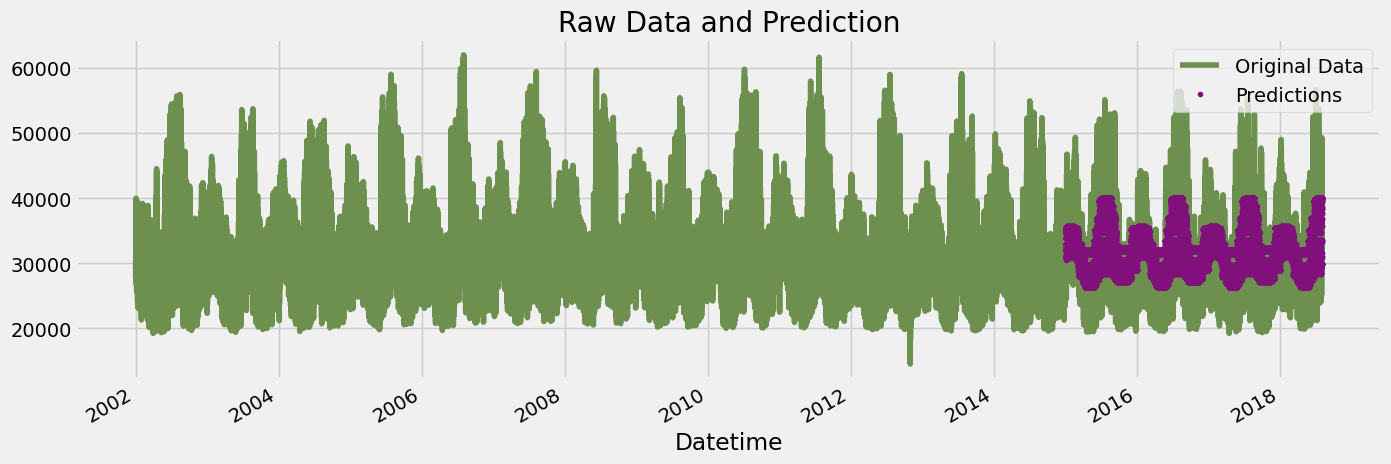

In [233]:
ax = df[['PJME_MW']].plot(figsize=(15,5),color=color_pal[3])
df['prediction'].plot(ax=ax, style='.',color=color_pal[5])
plt.legend(['Original Data','Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

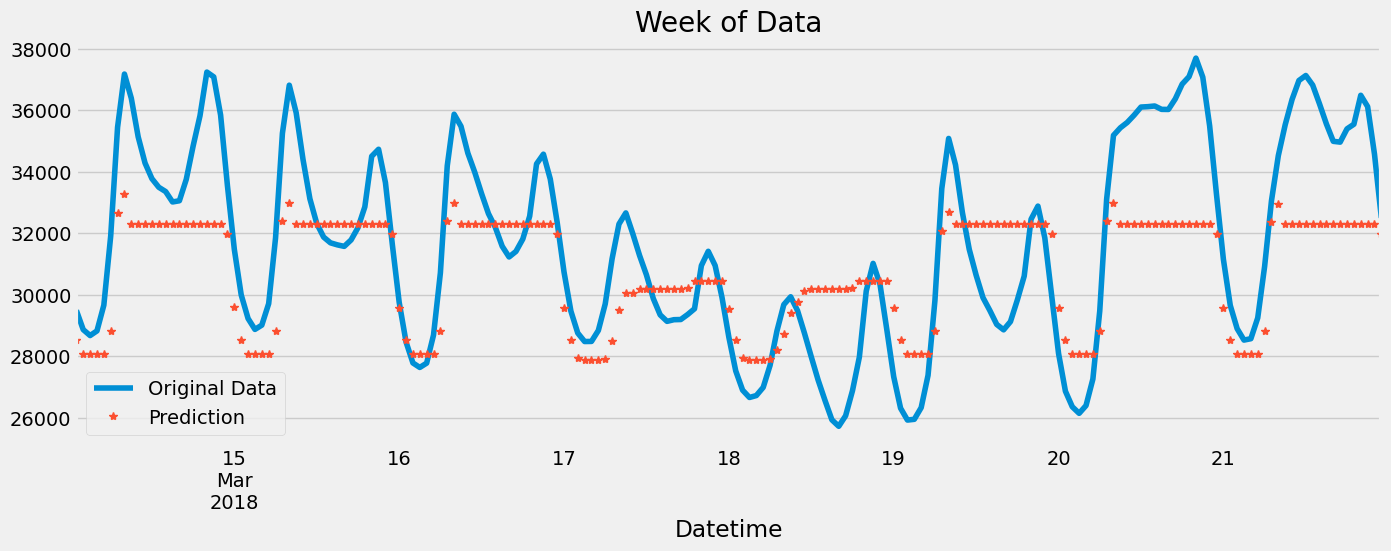

In [234]:
df.loc[(df.index >'03-14-2018') & (df.index < '03-22-2018')]['PJME_MW'] \
    .plot(figsize=(15,5),title='Week of Data')
df.loc[(df.index >'03-14-2018') & (df.index < '03-22-2018')]['prediction'] \
    .plot(style='*')
plt.legend(['Original Data','Prediction'])

In [237]:
score = np.sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))
print(f' RMSE Score on Test set: {score: 0.2f}')

 RMSE Score on Test set:  4325.35


### Calculating the Error

In [242]:
test['errors'] = np.abs(test[TARGET] - test['prediction'])
test['errors']


Datetime
2015-01-01 00:00:00     712.320312
2015-12-31 01:00:00    5364.609375
2015-12-31 02:00:00    5801.384766
2015-12-31 03:00:00    6443.384766
2015-12-31 04:00:00    6627.384766
                          ...     
2018-01-01 20:00:00    9064.652344
2018-01-01 21:00:00    8531.652344
2018-01-01 22:00:00    7263.023438
2018-01-01 23:00:00    5590.507812
2018-01-02 00:00:00    6518.320312
Name: errors, Length: 31440, dtype: float64

In [245]:
# Worst Predictions
test['date'] = test.index.date
test.groupby('date')['errors'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    12092.418620
2016-08-14    11407.225098
2018-01-06    11024.924316
2015-02-20    10791.006348
2016-09-09    10337.963704
Name: errors, dtype: float64

In [ ]:
# Best Predictions
test['date'] = test.index.date
test.groupby('date')['errors'].mean().sort_values(ascending=True).head(5)